In [25]:
import mlrose_hiive as mlr
import numpy as np
import sys
sys.path.append('./pyperch') 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from mlrose_hiive import SARunner, GARunner, RHCRunner, NNGSRunner

In [3]:
from pyperch.neural.backprop_nn import BackpropModule

In [4]:
print(BackpropModule)

<class 'pyperch.neural.backprop_nn.BackpropModule'>


In [4]:
# Problem 1 -- Warehouse Layout Optimization Problem
# Define the warehouse grid size
warehouse_size = (10, 10)  # 10x10 grid

# Generate random orders (for example purposes)
np.random.seed(42)
num_items = 50
num_orders = 20
orders = [np.random.choice(range(num_items), size=np.random.randint(1, 10), replace=False) for _ in range(num_orders)]

# Define entry/exit point
entry_point = (0, 0)

# Define Manhattan distance function
def manhattan_distance(point1, point2):
    return abs(point1[0] - point1[1]) + abs(point2[0] - point2[1])

# Create a mapping of items to grid positions (initial random layout)
initial_layout = {i: (np.random.randint(0, warehouse_size[0]), np.random.randint(0, warehouse_size[1])) for i in range(num_items)}

# Custom fitness function for warehouse layout
def warehouse_fitness(layout):
    layout_dict = {i: (layout[2*i], layout[2*i+1]) for i in range(num_items)}
    total_distance = 0

    for order in orders:
        # Calculate the total travel distance for the current order
        order_points = [entry_point] + [layout_dict[item] for item in order] + [entry_point]
        for i in range(len(order_points) - 1):
            total_distance += manhattan_distance(order_points[i], order_points[i+1])

    return total_distance

# Create a fitness object
fitness = mlr.CustomFitness(warehouse_fitness)

# Define optimization problem
problem = mlr.DiscreteOpt(length=2*num_items, fitness_fn=fitness, maximize=False, max_val=max(warehouse_size))

In [8]:
sa = SARunner(problem=problem,
              experiment_name='warehouse_sa',
              output_directory="./warehouse", # note: specify an output directory to have results saved to disk
              seed=42,
              iteration_list=2 ** np.arange(11),
              max_attempts=500,
              temperature_list=[0.1, 0.5, 0.75, 1.0, 2.0, 5.0],
              decay_list=[mlr.GeomDecay])

df_run_stats, df_run_curves = sa.run()

In [23]:
best_state = df_run_stats.loc[df_run_stats['Fitness'].idxmax()]['State']
best_fitness = df_run_stats['Fitness'].min()

best_fitness

34.0

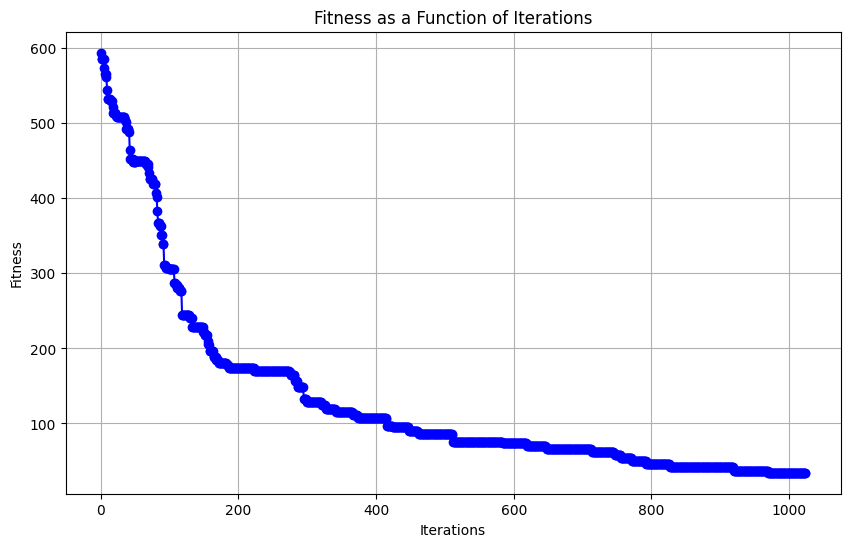

In [17]:
agg_fitness = df_run_curves.groupby('Iteration')['Fitness'].mean().reset_index()

# Extract iteration and fitness data
iterations = agg_fitness['Iteration']
fitness_values = agg_fitness['Fitness']

# Plot the fitness as a function of iterations
plt.figure(figsize=(10, 6))
plt.plot(iterations, fitness_values, marker='o', linestyle='-', color='b')
plt.title('Fitness as a Function of Iterations')
plt.xlabel('Iterations')
plt.ylabel('Fitness')
plt.grid(True)
plt.show()

In [ ]:
rhc = RHCRunner(problem=problem,
              experiment_name='warehouse_rhc',
              output_directory="./warehouse", # note: specify an output directory to have results saved to disk
              seed=42,
              iteration_list=2 ** np.arange(11),
              max_attempts=500,
              restart_list=[0, 5, 10, 25, 50, 100])

df_run_stats, df_run_curves = rhc.run()

In [ ]:
ga = GARunner(problem=problem,
              experiment_name='warehouse_rhc',
              output_directory="./warehouse", # note: specify an output directory to have results saved to disk
              seed=42,
              iteration_list=2 ** np.arange(11),
              max_attempts=500,
              population_sizes=[100, 200, 300],
              mutation_rates=[0.1, 0.15, 0.2])

wh_ga_run_stats, wh_ga_run_curves = ga.run()